In [19]:
from gc import enable

import ee
import altair as alt
import geemap.core as geemap
import matplotlib.pyplot as plt
import pandas as pd
from select import select

In [3]:

ee.Authenticate()
ee.Initialize(project='')

In [5]:

uttarakhand_aoi = ee.Geometry.Polygon([
    [[79.05, 30.75], [79.05, 30.85], [79.15, 30.85], [79.15, 30.75], [79.05, 30.75]]
])

Map = geemap.Map()
Map.centerObject(uttarakhand_aoi, 10)
Map.addLayer(uttarakhand_aoi, {}, "Uttarakhand AOI")
Map

Map(center=[30.800000925254462, 79.09999999999735], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [92]:
# Load Sentinel-1 SAR for Uttarakhand
sentinel1_uttarakhand = ee.ImageCollection("COPERNICUS/S1_GRD") \
    .filterBounds(uttarakhand_aoi) \
    .filterDate('2023-01-01', '2024-01-01') \
    .filter(ee.Filter.eq('instrumentMode', 'IW')) \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
    .select('VV')  # Use VV polarization for water detection




In [93]:
def detect_water(image):
    """Create a water mask using a backscatter threshold (-17 dB)"""
    water_mask = image.select('VV').lt(-17).rename('water')  # Low VV = Water
    return image.addBands(water_mask)

# Apply to all Sentinel-1 images
water_sars = sentinel1_uttarakhand.map(detect_water)


In [41]:
# Load Sentinel-2 optical data for Uttarakhand
sentinel2_uttarakhand = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
    .filterBounds(uttarakhand_aoi) \
    .filterDate('2023-01-01', '2023-12-31')

#NDWI
def add_ndwi(image):
    ndwi = image.normalizedDifference(['B3','B8']).rename('NDWI')
    return image.addBands(ndwi)

ndwi_sentinel2 = sentinel2_uttarakhand.map(add_ndwi)

In [ ]:
def calculate_lake_area(image):
    water_mask = image.select('NDWI').gt(0)  # NDWI > 0 is water
    area_dict = water_mask.multiply(ee.Image.pixelArea()).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=uttarakhand_aoi,
        scale=30,
        maxPixels=1e9
    )
    
    # Use ee.Algorithms.If() to replace None with 0
    area = ee.Algorithms.If(area_dict.contains('NDWI'), area_dict.get('NDWI'), 0)
    
    return ee.Feature(None, {'date': image.date().format(), 'area': area})

lake_areas = ndwi_sentinel2.map(calculate_lake_area)

In [70]:

# Extract NDWI values over time
# Extract timestamps (convert from milliseconds to datetime)
def mask_clouds(image):
    QA60 = image.select('QA60')  # Sentinel-2 cloud mask band
    cloud_mask = QA60.bitwiseAnd(1 << 10).eq(0)  # Keep pixels where clouds are absent
    return image.updateMask(cloud_mask)

# Apply cloud masking before NDWI calculation
sentinel2_uttarakhand = sentinel2_uttarakhand.map(mask_clouds)

def add_ndwi(image):
    ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI')
    return image.addBands(ndwi)

ndwi_sentinel2 = sentinel2_uttarakhand.map(add_ndwi)

ndwi_values = ndwi_sentinel2.aggregate_array('NDWI').getInfo()
print(ndwi_values[:5])



[]


In [69]:
first_image = sentinel2_uttarakhand.first()
print(first_image.bandNames().getInfo())  # Check available bands

print(sentinel2_uttarakhand.size().getInfo())




['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12', 'QA10', 'QA20', 'QA60', 'MSK_CLASSI_OPAQUE', 'MSK_CLASSI_CIRRUS', 'MSK_CLASSI_SNOW_ICE']
146


In [71]:
# Convert to DataFrame
#print(len(ndwi_dates), len(ndwi_values))
#print(ndwi_dates[:5])  # Check first few dates
print(ndwi_values[:5])  # Check first few NDWI values


[]


In [98]:
# Get median NDWI from Sentinel-2
sar_water_median = water_sars.median().select('water')

# Display the SAR water mask
Map.addLayer(sar_water_median, {'palette': ['black', 'cyan'], 'min': 0, 'max': 1}, 'SAR Water Mask')


ndwi_median = ndwi_sentinel2.median().select('NDWI')


# Overlay on the map
Map.addLayer(ndwi_median, {'palette': ['white', 'blue'], 'min': 0, 'max': 1}, 'NDWI Water')
Map.addLayer(sar_water_median, {'palette': ['black', 'cyan'], 'min': 0, 'max': 1}, 'SAR Water Mask')
Map

Map(center=[30.800000925254462, 79.09999999999735], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [24]:

# Load DEM for Uttarakhand
dem_uttarakhand = ee.Image('USGS/SRTMGL1_003').clip(uttarakhand_aoi)

# Add layers to the map
Map.addLayer(sentinel2_uttarakhand.median().select('B4', 'B3', 'B2'), 
             {'min': 0, 'max': 3000}, 'Sentinel-2 (True Color)')
Map.addLayer(dem_uttarakhand, {'min': 3000, 'max': 8000, 'palette': 'terrain'}, 'DEM')
Map



Map(center=[30.800000925254462, 79.09999999999735], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [26]:
print(lake_areas)

ee.ImageCollection({
  "functionInvocationValue": {
    "functionName": "Collection.map",
    "arguments": {
      "baseAlgorithm": {
        "functionDefinitionValue": {
          "argumentNames": [
            "_MAPPING_VAR_0_0"
          ],
          "body": {
            "functionInvocationValue": {
              "functionName": "Feature",
              "arguments": {
                "metadata": {
                  "dictionaryValue": {
                    "values": {
                      "area": {
                        "functionInvocationValue": {
                          "functionName": "Dictionary.get",
                          "arguments": {
                            "dictionary": {
                              "functionInvocationValue": {
                                "functionName": "Image.reduceRegion",
                                "arguments": {
                                  "geometry": {
                                    "functionInvocationValue": {
     

In [29]:
# Convert to Pandas DataFrame
lake_areas_list = lake_areas.aggregate_array('date').getInfo()
area_list = lake_areas.aggregate_array('area').getInfo()

                 date          area
0 2023-01-01 05:30:16  1.025122e+07
1 2023-01-04 05:40:10  2.354448e+07
2 2023-01-06 05:30:16  3.985558e+07
3 2023-01-09 05:40:11  2.795591e+06
4 2023-01-11 05:30:13  0.000000e+00


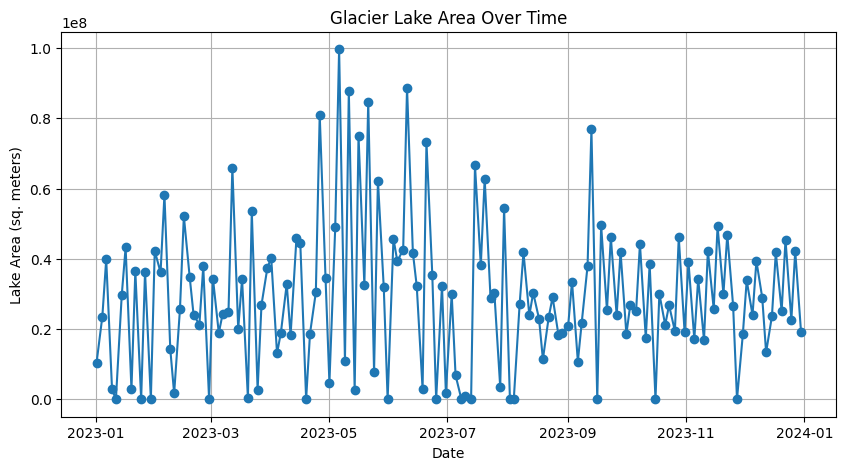

In [54]:




df = pd.DataFrame({'date': lake_areas_list, 'area': area_list})
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')
print(df.head())

# Plot Lake Area Changes Over Time
plt.figure(figsize=(10, 5))
plt.plot(df['date'], df['area'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Lake Area (sq. meters)')
plt.title('Glacier Lake Area Over Time')
plt.grid()
plt.show()


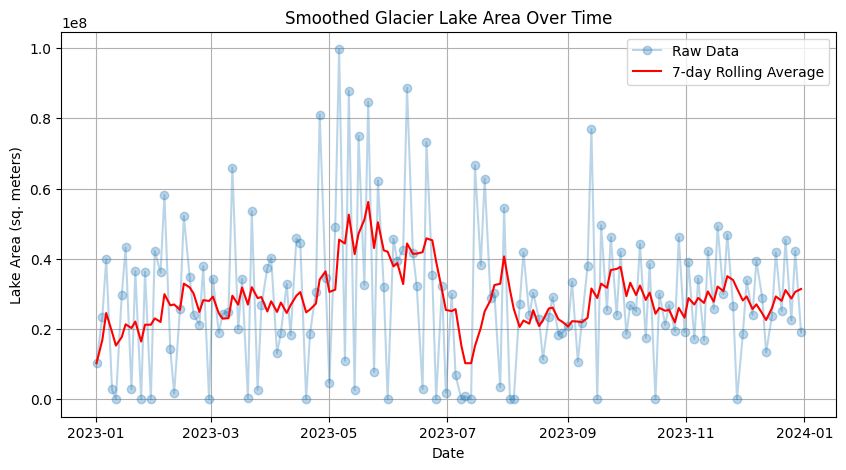

In [55]:
# Apply a 7-day rolling mean to smooth variations
df['area_smoothed'] = df['area'].rolling(window=7, min_periods=1).mean()

# Plot the smoothed trend
plt.figure(figsize=(10, 5))
plt.plot(df['date'], df['area'], marker='o', linestyle='-', alpha=0.3, label='Raw Data')
plt.plot(df['date'], df['area_smoothed'], color='red', linestyle='-', label='7-day Rolling Average')
plt.xlabel('Date')
plt.ylabel('Lake Area (sq. meters)')
plt.title('Smoothed Glacier Lake Area Over Time')
plt.legend()
plt.grid()
plt.show()


In [99]:
# Load Sentinel-1 SAR Collection

# Function to get mean backscatter over AOI
def compute_sar_stats(image):
    stats = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=uttarakhand_aoi,
        scale=30,
        maxPixels=1e9
    )
    return ee.Feature(None, {
        'date': image.date().format(),
        'VV': stats.get('VV'),
        'VH': stats.get('VH')
    })

# Apply function to SAR images
sar_features = sentinel1_uttarakhand.map(compute_sar_stats)

# Extract and convert to DataFrame
sar_dates = sar_features.aggregate_array('date').getInfo()
vv_list = sar_features.aggregate_array('VV').getInfo()
vh_list = sar_features.aggregate_array('VH').getInfo()

# Convert to Pandas DataFrame

df_sar = pd.DataFrame({'date': sar_dates, 'VV': vv_list, 'VH': vh_list})
df_sar['date'] = pd.to_datetime(df_sar['date'])
print(df.head())  # Check if dataframe has values
print(df.describe())
# Merge SAR data with lake area data
df_merged = df_ndwi.merge(df_sar, on='date', how='inner')  # Only common dates
print(df_merged.head())
  # Check statistics of the dataset

EEException: Collection.reduceColumns: Error in map(ID=S1A_IW_GRDH_1SDV_20230313T124759_20230313T124824_047626_05B854_39C9):
Dictionary.get: Dictionary does not contain key: 'VH'.

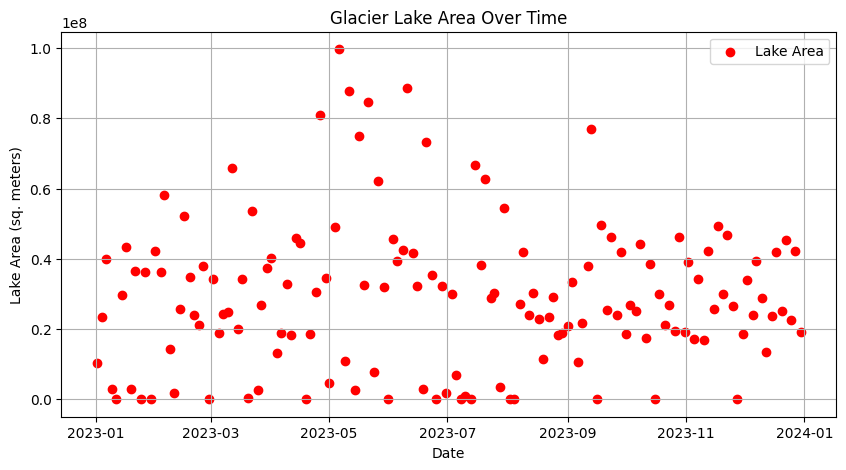

In [49]:

plt.figure(figsize=(10, 5))
plt.scatter(df['date'], df['area'], color='red', label='Lake Area')
plt.xlabel('Date')
plt.ylabel('Lake Area (sq. meters)')
plt.title('Glacier Lake Area Over Time')
plt.legend()
plt.grid()
plt.show()



In [75]:
def get_ndwi_value(image):
    ndwi_value = image.select('NDWI').reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=uttarakhand_aoi,
        scale=30,
        maxPixels=1e9
    ).get('NDWI')
    
    return ee.Feature(None, {'date': image.date().format(), 'NDWI': ndwi_value})

ndwi_features = ndwi_sentinel2.map(get_ndwi_value)


In [77]:
ndwi_dates = ndwi_features.aggregate_array('date').getInfo()
ndwi_values = ndwi_features.aggregate_array('NDWI').getInfo()
print(len(ndwi_dates), len(ndwi_values))  # Should be the same and > 0


146 146


In [78]:
df_ndwi = pd.DataFrame({'date': ndwi_dates, 'NDWI': ndwi_values})

# Convert 'date' to datetime
df_ndwi['date'] = pd.to_datetime(df_ndwi['date'])

# Handle missing NDWI values (replace None/NaN with 0)
df_ndwi['NDWI'] = pd.to_numeric(df_ndwi['NDWI'], errors='coerce')  # Convert to float
df_ndwi.fillna(0, inplace=True)  # Replace NaNs with 0

print(df_ndwi.head()) 

                 date      NDWI
0 2023-01-01 05:30:16 -0.016508
1 2023-01-04 05:40:10  0.009478
2 2023-01-06 05:30:16  0.018961
3 2023-01-09 05:40:11 -0.021043
4 2023-01-11 05:30:13 -0.032146


In [79]:
df_merged = df_ndwi.merge(df_sar, on='date', how='inner')  # Merge only common dates

In [80]:
print(df_ndwi['date'].head())  
print(df_sar['date'].head())


0   2023-01-01 05:30:16
1   2023-01-04 05:40:10
2   2023-01-06 05:30:16
3   2023-01-09 05:40:11
4   2023-01-11 05:30:13
Name: date, dtype: datetime64[ns]
0   2023-01-08 00:43:33
1   2023-02-01 00:43:32
2   2023-02-13 00:43:31
3   2023-02-25 00:43:31
4   2023-04-26 00:43:32
Name: date, dtype: datetime64[ns]


In [81]:
print(df_ndwi.describe())

                                date        NDWI
count                            146  146.000000
mean   2023-07-01 17:35:15.767123200   -0.004282
min              2023-01-01 05:30:16   -0.056188
25%       2023-04-01 23:32:49.500000   -0.017047
50%       2023-07-01 17:35:19.500000   -0.003276
75%       2023-09-30 11:37:45.500000    0.010589
max              2023-12-30 05:40:13    0.042816
std                              NaN    0.019902


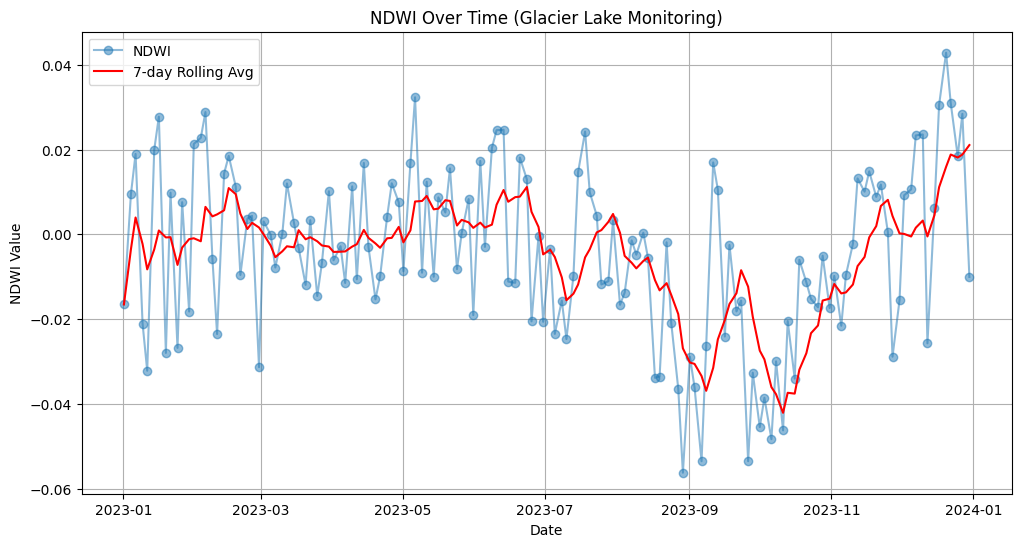

In [88]:
plt.figure(figsize=(12, 6))
plt.plot(df_ndwi['date'], df_ndwi['NDWI'], marker='o', linestyle='-', alpha=0.5, label='NDWI')

# Add a 7-day rolling mean for smoothing
df_ndwi['NDWI_smoothed'] = df_ndwi['NDWI'].rolling(window=7, min_periods=1).mean()
plt.plot(df_ndwi['date'], df_ndwi['NDWI_smoothed'], color='red', linestyle='-', label='7-day Rolling Avg')

# Labels and title
plt.xlabel('Date')
plt.ylabel('NDWI Value')
plt.title('NDWI Over Time (Glacier Lake Monitoring)')
plt.legend()
plt.grid()

# Show the plot
plt.show()



In [102]:
# Check available bands in Sentinel-1 collection
first_image = sentinel1_uttarakhand.first()
print(first_image.bandNames().getInfo())  # Print available bands

['VV']


In [103]:
def detect_water(image):
    """Apply water detection on Sentinel-1 SAR using a VV threshold"""
    vv_band = image.select('VV')  # Make sure VV exists
    water_mask = vv_band.lt(-17).rename('water')  # Detect water
    return image.addBands(water_mask)  # Ensure 'water' band is added

# Apply function to all images
water_sar = sentinel1_uttarakhand.map(detect_water)

# Check if water band is correctly added
first_water_image = water_sar.first()
print(first_water_image.bandNames().getInfo())  # Should include 'VV' and 'water'


['VV', 'water']


In [104]:
# Function to calculate water area for both NDWI and SAR
# Extract the first image from the processed SAR collection
first_image = water_sar.first()
print(first_image.bandNames().getInfo())  # Should contain ['VV', 'water']

['VV', 'water']


In [106]:
# Get the median water mask
sar_water_median = water_sar.median().select('water')

# Get median NDWI from Sentinel-2
ndwi_median = ndwi_sentinel2.median().select('NDWI')

# Add layers to map
Map.addLayer(ndwi_median, {'palette': ['white', 'blue'], 'min': 0, 'max': 1}, 'NDWI Water')
Map.addLayer(sar_water_median, {'palette': ['black', 'cyan'], 'min': 0, 'max': 1}, 'SAR Water Mask')
Map

Map(center=[30.800000925254462, 79.09999999999735], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [108]:
print(water_sar.size().getInfo())  # Should be > 0
print(water_sar.first().bandNames().getInfo())  # Should include 'water'

50
['VV', 'water']


In [111]:
print(first_image.bandNames().getInfo())  # Check if 'water' is present

['VV', 'water']


In [126]:
def calculate_water_area(image):
    """Calculates water area from NDWI and SAR water masks"""
    # Ensure band names exist
    ndwi_water = image.select('NDWI').gt(0).rename('NDWI_Water')  # NDWI > 0 = water
    sar_water = image.select('water').rename('SAR_Water')  # SAR-detected water

    area_ndwi = ndwi_water.multiply(ee.Image.pixelArea()).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=uttarakhand_aoi,
        scale=30,
        maxPixels=1e9
    )

    area_sar = sar_water.multiply(ee.Image.pixelArea()).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=uttarakhand_aoi,
        scale=30,
        maxPixels=1e9
    )

    return ee.Feature(None, {
        'date': image.date().format(),
        'area_ndwi': area_ndwi.get('NDWI_Water', 0),
        'area_sar': area_sar.get('SAR_Water', 0)
    })

# Map function over Sentinel-2 images
lake_areas_combined = ndwi_sentinel2.map(calculate_water_area)

# Debug: Check if the collection contains data
print("Total processed images:", lake_areas_combined.size().getInfo())

# Convert to Pandas DataFrame
dates = lake_areas_combined.aggregate_array('date').getInfo()
ndwi_areas = lake_areas_combined.aggregate_array('area_ndwi').getInfo()
sar_areas = lake_areas_combined.aggregate_array('area_sar').getInfo()

# Ensure lengths match before creating DataFrame
if len(dates) == len(ndwi_areas) == len(sar_areas):
        df_combined = pd.DataFrame({'date': dates, 'NDWI_Area': ndwi_areas, 'SAR_Area': sar_areas})
        df_combined['date'] = pd.to_datetime(df_combined['date'])

    # Plot NDWI vs SAR Water Area
        plt.figure(figsize=(10, 5))
        plt.plot(df_combined['date'], df_combined['NDWI_Area'], marker='o', linestyle='-', label='NDWI-based Area')
        plt.plot(df_combined['date'], df_combined['SAR_Area'], marker='s', linestyle='--', label='SAR-based Area', alpha=0.7)
        plt.xlabel('Date')
        plt.ylabel('Lake Area (sq. meters)')
        plt.title('Comparison of NDWI & SAR Water Area')
        plt.legend()
        plt.grid()
        plt.show()
else:
        print("Error: Mismatched array lengths:", len(dates), len(ndwi_areas), len(sar_areas))



Total processed images: 146


EEException: Collection.reduceColumns: Error in map(ID=20230101T052229_20230101T052722_T44RLV):
Image.select: Band pattern 'water' did not match any bands. Available bands: [B1, B2, B3, B4, B5, B6, B7, B8, B8A, B9, B10, B11, B12, QA10, QA20, QA60, MSK_CLASSI_OPAQUE, MSK_CLASSI_CIRRUS, MSK_CLASSI_SNOW_ICE, NDWI]